In [1]:
# Read data and aggregate into monthly sale_cnt and avg_price of shop_item

import pandas as pd

train_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
# columns: date, date_block_num, shop_id, item_id, item_price, item_cnt_day
train_monthly_df = train_df.groupby(['date_block_num','shop_id','item_id']).agg(item_cnt_month=('item_cnt_day','sum'), price_avg_month=('item_price','mean')).reset_index()
train_monthly_df['shop_item'] = train_monthly_df['shop_id'].astype('string') + '-' + train_monthly_df['item_id'].astype('string')

shop_item_list = pd.unique(train_monthly_df['shop_item'])
print("cnt of shop_item:",len(shop_item_list))
print('max shop id:', max(train_monthly_df.shop_id))
print('max item id:', max(train_monthly_df.item_id))
train_monthly_df

cnt of shop_item: 424124
max shop id: 59
max item id: 22169


,date_block_num,shop_id,item_id,item_cnt_month,price_avg_month,shop_item
0,0,0,32,6.0,221.0,0-32
1,0,0,33,3.0,347.0,0-33
2,0,0,35,1.0,247.0,0-35
3,0,0,43,1.0,221.0,0-43
4,0,0,51,2.0,128.5,0-51
...,...,...,...,...,...,...
1609119,33,59,22087,6.0,119.0,59-22087
1609120,33,59,22088,2.0,119.0,59-22088
1609121,33,59,22091,1.0,179.0,59-22091
1609122,33,59,22100,1.0,629.0,59-22100


In [2]:
# get the avg_price of each shop_item as default price

shopitem_price_df = train_monthly_df.groupby(['shop_item']).agg(price=('price_avg_month','mean'))
shopitem_price_dict = {}
for idx, row in shopitem_price_df.iterrows():
    shopitem_price_dict[idx] = row['price']
len(shopitem_price_dict)

424124

In [3]:
# get the sale_cnt and price sequences of each shop_item

import numpy as np

data_seq_dict = {}
for shop_item in shop_item_list:
    shop_id = float(shop_item.split('-')[0])
    item_id = float(shop_item.split('-')[1])
    data_seq_dict[shop_item] = [[0.0, shopitem_price_dict[shop_item], shop_id, item_id, float(i%12)] for i in range(0,34)]
for _, row in train_monthly_df.iterrows():
    data_seq_dict[row['shop_item']][int(row['date_block_num'])][0] = row['item_cnt_month']
    data_seq_dict[row['shop_item']][int(row['date_block_num'])][1] = row['price_avg_month']

data_seq_array = np.array(list(data_seq_dict.values()))
print(data_seq_array.shape)  # (424124, 34, 5)
print(data_seq_array)  # (sales_cnt, price, shop_id, item_id, month)

(424124, 34, 5)
[[[6.0000e+00 2.2100e+02 0.0000e+00 3.2000e+01 0.0000e+00]
  [1.0000e+01 2.2100e+02 0.0000e+00 3.2000e+01 1.0000e+00]
  [0.0000e+00 2.2100e+02 0.0000e+00 3.2000e+01 2.0000e+00]
  ...
  [0.0000e+00 2.2100e+02 0.0000e+00 3.2000e+01 7.0000e+00]
  [0.0000e+00 2.2100e+02 0.0000e+00 3.2000e+01 8.0000e+00]
  [0.0000e+00 2.2100e+02 0.0000e+00 3.2000e+01 9.0000e+00]]

 [[3.0000e+00 3.4700e+02 0.0000e+00 3.3000e+01 0.0000e+00]
  [3.0000e+00 3.4700e+02 0.0000e+00 3.3000e+01 1.0000e+00]
  [0.0000e+00 3.4700e+02 0.0000e+00 3.3000e+01 2.0000e+00]
  ...
  [0.0000e+00 3.4700e+02 0.0000e+00 3.3000e+01 7.0000e+00]
  [0.0000e+00 3.4700e+02 0.0000e+00 3.3000e+01 8.0000e+00]
  [0.0000e+00 3.4700e+02 0.0000e+00 3.3000e+01 9.0000e+00]]

 [[1.0000e+00 2.4700e+02 0.0000e+00 3.5000e+01 0.0000e+00]
  [1.4000e+01 2.4700e+02 0.0000e+00 3.5000e+01 1.0000e+00]
  [0.0000e+00 2.4700e+02 0.0000e+00 3.5000e+01 2.0000e+00]
  ...
  [0.0000e+00 2.4700e+02 0.0000e+00 3.5000e+01 7.0000e+00]
  [0.0000e+00 2.47

In [4]:
# get the avg sale_cnt and price of each item as default sequences

item_seq_dict = {}
item_seq_num_dict = {}
for k, v in data_seq_dict.items():
    item = k.split('-')[1]
    if item not in item_seq_dict.keys():
        item_seq_dict[item] = v
        item_seq_num_dict[item] = 1
    else:
        item_seq_dict[item] = [[a+b for a, b in zip(i, j)] for i, j in zip(item_seq_dict[item], v)]
        item_seq_num_dict[item] += 1
for item in item_seq_dict.keys():
    item_seq_dict[item] = [[e / item_seq_num_dict[item] for e in step] for step in item_seq_dict[item]]

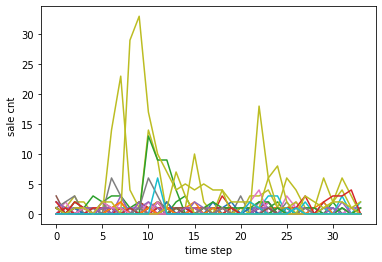

In [5]:
# plot curve

import matplotlib.pyplot as plt

row_random_array = np.arange(data_seq_array.shape[0])
np.random.shuffle(row_random_array)
row_random = data_seq_array[row_random_array][0:100,:,0]
for seq in row_random:
    plt.plot(seq)
plt.xlabel('time step')
plt.ylabel('sale cnt')
plt.show()

MQ-R(C)NN

features
* $y$ is sales_cnt
* $x^h$ (history) is (price, month)
* $x^f$ (future) is (price, month)
* $x^s$ is (shop_id, item_id)

input 1 historical data
* features = ($y$, $x^h$, $x^s$) = (sales_cnt, price, shop_id, item_id, month)
* shape = (batch_size, steps, dim_h) = (N, 33, 5)

input 2 future data
* features = ($x^f$) = (price, month)
* shape = (batch_size, steps, horizons, dim_f) = (N, 33, 1, 2)

ground truth
* (sales_cnt)
* shape = (batch_size, steps, horizons, num_quantiles) = (N, 33, 1, 3)

In [6]:
# because the distinct item is too much and embedding lookup table is so large that OOM, mod a vocab_size
ITEM_VOCAB_SIZE = 100
data_seq_array[:,:,3] = data_seq_array[:,:,3] % ITEM_VOCAB_SIZE

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from numpy.lib.stride_tricks import sliding_window_view

# Split X and Y
# if horizon > 1, need to pad
# X = np.pad(data_seq_array, ((0,0),(0,pad_len),(0,0)), 'constant', constant_values=0)  # Note to change the padding according with Conv kernel_size and stride
X = data_seq_array[:,:-1,:]  # (N, 33, 5)
Y = data_seq_array[:,1:,0]  # (N, 33, 1)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25)

X_train_input1 = X_train  # (N, steps, dim_h) = (N, 33, 5)
X_train_input2 = X_train[:,:,[1,4]]  # (N, 33, 2)
X_train_input2 = sliding_window_view(X_train_input2,1,axis=1)  # （N, 33, 2, 1）
X_train_input2 = np.transpose(X_train_input2,(0,1,3,2))  # (N, steps, horizons, dim_f) =（N, 33, 1, 2）

X_val_input1 = X_val  # (N, steps, dim_h) = (N, 33, 5)
X_val_input2 = X_val[:,:,[1,4]]  # (N, 33, 2)
X_val_input2 = sliding_window_view(X_val_input2,1,axis=1)  # （N, 33, 2, 1）
X_val_input2 = np.transpose(X_val_input2,(0,1,3,2))  # (N, steps, horizons, dim_f) =（N, 33, 1, 2）

Y_train = sliding_window_view(Y_train,1,axis=1)  # （N, 33, 1）
Y_train = Y_train[:,:,:,np.newaxis]
Y_train = np.tile(Y_train, 3)  # (N, steps, horizons, num_quantiles) =（N, 33, 3）

Y_val = sliding_window_view(Y_val,1,axis=1)  # （N, 33, 1）
Y_val = Y_val[:,:,:,np.newaxis]
Y_val = np.tile(Y_val, 3)  # (N, steps, horizons, num_quantiles) =（N, 33, 3）

In [8]:
# model parameters
PAD_LEN = 1
GLOBALMLP_AGNOSTIC_CTX_SIZE = 4
GLOBALMLP_SPECIFIC_CTX_SIZE = 4
STEP_LEN = X_train_input1.shape[1]
HORIZON_LEN = 1
EMB_SIZE = 4
QUANTILES = [0.1, 0.5, 0.9]

In [9]:
# MQ-R(C)NN
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from math import log
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import feature_column
from tensorflow.nn import relu
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Lambda, Concatenate, Reshape, Embedding, Conv1D, Add, Flatten, LSTM
from tensorflow.keras.optimizers import Adam

def quantile_loss(y_true, y_pred):
    # y_true shape: (N, steps, horizons, num_quantiles)
    # y_pred shape: (N, steps, horizons, num_quantiles)
    quantiles = tf.constant(QUANTILES)
    loss = tf.reduce_mean(quantiles * relu(y_true - y_pred) + (1 - quantiles) * relu(y_pred - y_true))
    return loss

class globalMLP_Layer(tf.keras.layers.Layer):
    def __init__(self,name=None):
        super(globalMLP_Layer, self).__init__(name=name)
        self.dense1 = Dense(8, activation='relu', name='globalMLP_1')
        self.dense2 = Dense(GLOBALMLP_SPECIFIC_CTX_SIZE * HORIZON_LEN + GLOBALMLP_AGNOSTIC_CTX_SIZE, activation='relu', name='globalMLP_2')

    def call(self, input):
        globalMLP_vec = self.dense1(input)
        output = self.dense2(globalMLP_vec)
        return output

class localMLP_Layer(tf.keras.layers.Layer):
    def __init__(self,name=None):
        super(localMLP_Layer, self).__init__(name=name)
        self.dense1 = Dense(8, activation='relu', name='localMLP_1')
        self.dense2 = Dense(len(QUANTILES), activation='relu', name='localMLP_2')

    def call(self, input):
        localMLP_vec = self.dense1(input)
        output = self.dense2(localMLP_vec)
        return output


# model
input_h_vec = Input(name='input_h', shape = (X_train_input1.shape[1], X_train_input1.shape[2]))  # （N, steps, dim_h）
input_f_vec = Input(name='input_f', shape = (X_train_input2.shape[1], X_train_input2.shape[2], X_train_input2.shape[3]))  # (N, steps, horizon, dim_f)

# embedding
Emb_shop_layer = Embedding(input_dim=60, output_dim=EMB_SIZE, input_length=STEP_LEN, name='Embedding_shop')
Emb_item_layer = Embedding(input_dim=ITEM_VOCAB_SIZE, output_dim=2, input_length=STEP_LEN, name='Embedding_item')
Emb_month_layer = Embedding(input_dim=13, output_dim=EMB_SIZE, input_length=STEP_LEN, name='Embedding_month')
# input h embedding
input_h_num_vec = Lambda(lambda x: tf.slice(x,(0,0,0),(-1,-1,2)),name='input_h_num_slice')(input_h_vec)  # (N, steps, 2)
input_h_shop_vec = Lambda(lambda x: tf.reshape(tf.slice(x,(0,0,2),(-1,-1,1)),(-1,STEP_LEN)),name='input_h_shop_slice')(input_h_vec)  # (N, steps)
input_h_item_vec = Lambda(lambda x: tf.reshape(tf.slice(x,(0,0,3),(-1,-1,1)),(-1,STEP_LEN)),name='input_h_item_slice')(input_h_vec)  # (N, steps)
input_h_month_vec = Lambda(lambda x: tf.reshape(tf.slice(x,(0,0,4),(-1,-1,1)),(-1,STEP_LEN)),name='input_h_month_slice')(input_h_vec)  # (N, steps)
input_h_shop_emb_vec = Emb_shop_layer(input_h_shop_vec)  # (n, steps, emb_size)
input_h_item_emb_vec = Emb_item_layer(input_h_item_vec)  # (n, steps, emb_size)
input_h_month_emb_vec = Emb_month_layer(input_h_month_vec)  # (n, steps, emb_size)
h_feature_vec = Lambda(lambda x: tf.concat(x,axis=2), name='h_feature_stack')([input_h_num_vec, input_h_shop_emb_vec, input_h_item_emb_vec, input_h_month_emb_vec])  # (N, steps, 12)
# input f embedding
input_f_num_vec = Lambda(lambda x: tf.slice(x,(0,0,0,0),(-1,-1,-1,1)),name='input_f_num_slice')(input_f_vec)  # (N, steps, horizon, 1)
input_f_month_vec = Lambda(lambda x: tf.reshape(tf.slice(x,(0,0,0,1),(-1,-1,-1,1)),(-1,STEP_LEN*HORIZON_LEN)),name='input_f_month_slice_reshape')(input_f_vec)  # (N, steps * horizon * 1)
input_f_month_emb_vec = Emb_month_layer(input_f_month_vec)  # (n, steps * horizon * 1, 4)
input_f_month_emb_vec = Lambda(lambda x: tf.reshape(x, (-1,STEP_LEN,HORIZON_LEN,EMB_SIZE)),name='input_f_month_emb_reshape')(input_f_month_emb_vec)  # (N, steps, horizon, emb_size)
f_feature_vec = Lambda(lambda x: tf.concat(x,axis=3), name='f_feature_stack')([input_f_num_vec, input_f_month_emb_vec])  # (N, steps, horizon, 1+emb_size)

# encoder_RNN
# encoder_outputs = LSTM(4, return_sequences=True, name='encoder')(h_feature_vec) # output shape: (N, steps, hidden_state_size)

# encoder_CNN
encoder_outputs = Conv1D(filters=4,kernel_size=4,strides=1,padding='causal',dilation_rate=1,name='encoder_CNN_1')(h_feature_vec)  # output shape: (N, steps, hidden_state_size)
encoder_outputs = Conv1D(filters=4,kernel_size=4,strides=1,padding='causal',dilation_rate=2,name='encoder_CNN_2')(encoder_outputs)  # output shape: (N, steps, hidden_state_size)
encoder_outputs = Conv1D(filters=4,kernel_size=4,strides=1,padding='causal',dilation_rate=4,name='encoder_CNN_3')(encoder_outputs)  # output shape: (N, steps, hidden_state_size)

# decoder
globalMLP_Layer = globalMLP_Layer(name='globalMLP')
localMLP_Layer = localMLP_Layer(name='localMLP')
step_predictions = []
for i in range(STEP_LEN):
    hidden_state_vec = Lambda(lambda x: tf.slice(x, (0,i,0),(-1,1,-1)), name='hidden_state_slice_{}'.format(i))(encoder_outputs)  # (N, 1, hidden_state_size)
    hidden_state_vec = Flatten(name='hidden_state_flatten_{}'.format(i))(hidden_state_vec)  # (N, hidden_state_size)
    future_input_i_vec = Lambda(lambda x: tf.slice(x, (0,i,0,0),(-1,1,-1,-1)), name='future_input_slice_{}'.format(i))(f_feature_vec)  # (N, 1, horizon, dim_f)
    future_input_i_vec = Flatten(name='future_input_flatten_{}'.format(i))(future_input_i_vec)  # (N, horizon * dim_f)=(N,1*(1+4))
    globalMLP_vec = Concatenate(axis=1, name='globalMLP_step_{}_input'.format(i))([hidden_state_vec, future_input_i_vec])  # (N, hidden_state_len + horizon * dim_f)
    globalMLP_vec = globalMLP_Layer(globalMLP_vec)  # (N, horizon * horizon_specific_ctx_size + horizon_agnostic_ctx_size)
    horizon_predictions = []
    agnostic_ctx_vec = Lambda(lambda x: tf.slice(x, (0, HORIZON_LEN * GLOBALMLP_SPECIFIC_CTX_SIZE), (-1, GLOBALMLP_AGNOSTIC_CTX_SIZE)),name='globalMLP_slice_{}_agnostic_ctx'.format(i))(globalMLP_vec)  # (N, GLOBALMLP_AGNOSTIC_CTX_SIZE)
    for j in range(HORIZON_LEN):
        specific_ctx_vec = Lambda(lambda x: tf.slice(x, (0,j * GLOBALMLP_SPECIFIC_CTX_SIZE), (-1, GLOBALMLP_SPECIFIC_CTX_SIZE)), name='globalMLP_slice_{}_specific_ctx_{}'.format(i,j))(globalMLP_vec)  # (N, GLOBALMLP_SPECIFIC_CTX_SIZE)
        DIM_F = input_f_num_vec.shape[3] + EMB_SIZE
        future_input_ij_vec = Lambda(lambda x: tf.slice(x, (0, j * DIM_F),(-1,DIM_F)), name='future_input_slice_{}_horizon_{}'.format(i,j))(future_input_i_vec)  # (N, DIM_F)
        localMLP_vec = Concatenate(axis=1, name='localMLP_step_{}_horizon_{}_input'.format(i,j))([agnostic_ctx_vec, specific_ctx_vec, future_input_ij_vec])  # (N, GLOBALMLP_AGNOSTIC_CTX_SIZE + GLOBALMLP_SPECIFIC_CTX_SIZE + DIM_F)=(N,4+4+5)
        localMLP_vec = localMLP_Layer(localMLP_vec)  # (N, num_quantiles)
        horizon_predictions.append(localMLP_vec)
    horizon_pred_vec = Lambda(lambda x: tf.stack(x,axis=1),name='horizon_stack_{}'.format(i))(horizon_predictions)  # (N, horizon, num_quantiles)
    step_predictions.append(horizon_pred_vec)
output_vec = Lambda(lambda x: tf.stack(x,axis=1),name='FCTstep_stack')(step_predictions)  # (N, step, horizon, num_quantiles)

model = Model(inputs=[input_h_vec,input_f_vec], outputs=[output_vec])
model.compile(loss=quantile_loss, optimizer=Adam(learning_rate=0.01))
model.summary()

history = model.fit(x={'input_h': X_train_input1, 'input_f': X_train_input2}, 
                    y=Y_train, 
                    validation_data=({'input_h':X_val_input1,'input_f':X_val_input2}, Y_val), 
                    epochs=30, 
                    batch_size=1024*1024)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_h (InputLayer)            [(None, 33, 5)]      0                                            
__________________________________________________________________________________________________
input_h_shop_slice (Lambda)     (None, 33)           0           input_h[0][0]                    
__________________________________________________________________________________________________
input_h_item_slice (Lambda)     (None, 33)           0           input_h[0][0]                    
__________________________________________________________________________________________________
input_h_month_slice (Lambda)    (None, 33)           0           input_h[0][0]                    
______________________________________________________________________________________________

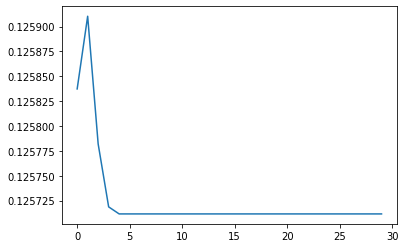

In [10]:
plt.plot(history.history['val_loss'])
plt.show()

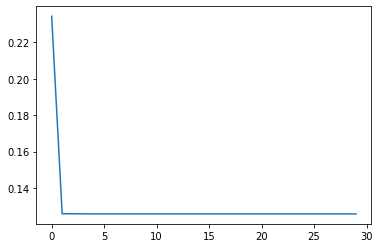

In [11]:
plt.plot(history.history['loss'])
plt.show()

In [12]:
# Prepare Test dataset

test_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
test_df['shop_item'] = test_df['shop_id'].astype('string') + '-' + test_df['item_id'].astype('string')

X_test = []
for _, row in test_df.iterrows():
    shop_item = row['shop_item']
    shop_id = row['shop_id']
    item_id = row['item_id']
    if shop_item in data_seq_dict.keys():
        sale_seq = np.array(data_seq_dict[shop_item])[:,0]
        price_seq = np.array(data_seq_dict[shop_item])[:,1]
    elif row['item_id'] in item_seq_dict.keys():
        sale_seq = np.array(item_seq_dict[item_id])[:,0]
        price_seq = np.array(item_seq_dict[item_id])[:,1]
        print('No shop-item', item_id, 'observed in training samples.')
    else:
        sale_seq = np.array([0.0 for i in range(0,34)])
        price_seq = np.array([0.0 for i in range(0,34)])
    shop_id_seq = np.array([float(shop_id) for i in range(len(seq))])
    item_id_seq = np.array([float(item_id) for i in range(len(seq))])
    month_seq = np.array([float(i%12) for i in range(len(seq))])
    X_test.append(np.stack([sale_seq, price_seq, shop_id_seq, item_id_seq, month_seq], axis=1))
X_test = np.stack(X_test, axis=0)  # (N, 34, 5)

X_test[:,:,3] = X_test[:,:,3] % ITEM_VOCAB_SIZE

X_test_input_h = X_test[:,1:,:]  # (N, 33, 5)
X_test_input_f = X_test[:,2:,[1,4]]  # (N, 32, 2)
X_test_input_f_forecast_part = X_test_input_f[:,-1,:]  # (N,2)
X_test_input_f_forecast_part = X_test_input_f_forecast_part[:,np.newaxis,:]  # (N,1,2)
X_test_input_f_forecast_part = np.tile(X_test_input_f_forecast_part,(1,HORIZON_LEN,1))  # (N,horizon,2)
X_test_input_f_forecast_part_price = X_test_input_f_forecast_part[:,:,0]  # (N,horizon)
X_test_input_f_forecast_part_month = (X_test_input_f_forecast_part[:,:,1] + np.array(range(1,HORIZON_LEN+1))) % 12  #(N,horizon)
X_test_input_f_forecast_part = np.stack([X_test_input_f_forecast_part_price,X_test_input_f_forecast_part_month], axis=2)  # (N,horizon,2)
X_test_input_f = np.concatenate([X_test_input_f,X_test_input_f_forecast_part],axis=1)  # (N,32+horizon,2)
X_test_input_f = sliding_window_view(X_test_input_f,1,axis=1).transpose(0,1,3,2)  # (N,32+horizon,horzion,2)

In [13]:
pred = model.predict({'input_h':X_test_input_h, 'input_f':X_test_input_f})

In [14]:
result = pred[:,-1,:,1]
print(result.shape)

(214200, 1)


In [15]:
# recover the prediction (de-normalized)
result[result<0] = 0.0
result

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [16]:
submission_df = pd.DataFrame(result, columns=['item_cnt_month'])
submission_df.index.name = 'ID'
submission_df

,item_cnt_month
ID,
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
214195,0.0
214196,0.0
214197,0.0


In [17]:
submission_df.to_csv('/kaggle/working/submission.csv')